# Processing the data

In [1]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import time

Using TensorFlow backend.


In [2]:
# Reproducibility
seed = 8 # arbitrary number
np.random.seed(seed=seed)
tf.random.set_seed(seed=seed)

In [3]:
physical_devices_cpu = tf.config.experimental.list_physical_devices('CPU')
print('CPUs Available: ' ,len(physical_devices_cpu))
physical_devices_gpu = tf.config.experimental.list_physical_devices('GPU')
print('GPUs Available: ' ,len(physical_devices_gpu))

CPUs Available:  1
GPUs Available:  0


In [4]:
def processing_data(N_channels, file_path):
    df = pd.read_csv(file_path)
    dataset = df.values
    # dataset
    dataset = df.values
    # input power and channels statuses
    X = dataset[:,0:N_channels+1]
    # channel SNRs
    Y = dataset[:,N_channels+1:2*N_channels+1]
    # shuffle necessary because while shuffle=True in .fit() shuffles the data, it splits into different datasets first
    X, Y = shuffle(X, Y)
    # scaling between 0 and 1
    min_max_scaler = preprocessing.MinMaxScaler()
    X_scale = min_max_scaler.fit_transform(X)
    Y_scale = min_max_scaler.fit_transform(Y)
    X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y_scale, test_size=0.3)
    X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
    print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

# Visualising the Model

In [5]:
def visualising_data(hist):
    plt.title('Mean Squared Error')
    plt.plot(hist.history['mean_squared_error'], label='Train')
    plt.plot(hist.history['val_loss'], label='Test')
    plt.legend()
    plt.show()
#     plt.plot(hist.history['mean_absolute_error'], label='Train')
#     plt.plot(hist.history['val_mean_absolute_error'], label='Test')
#     plt.legend()
#     plt.show()

# Building the ANN

In [6]:
def build_model(N_channels, file_path):
    X_train, Y_train, X_val, Y_val, X_test, Y_test = processing_data(N_channels, file_path)
    model = Sequential()
#     kernel_regularizer=regularizers.l2(0.00001)  - ADD THIS AT SOME POINT
    model.add(Dense(80, activation='relu', input_dim=N_channels+1))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(N_channels, activation='sigmoid'))
    # learning_rate=0.1 causes zig-zags, learning_rate=0.0001 is far too slow
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error'])
    # fit as we are fitting the parameters to the data
    # verbose shows how much info is shown during model fitting
    # shuffle by default set to true so this is for visual purposes
    start_time = time.time()
    hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=1, batch_size=N_channels+1)
    print("--- %s seconds ---" % (time.time() - start_time))
    return hist, model, X_train, Y_train, X_val, Y_val, X_test, Y_test

In [7]:
def evaluate_model(N_channels, file_path):
    hist, model, X_train, Y_train, X_val, Y_val, X_test, Y_test = build_model(N_channels, file_path)
    visualising_data(hist)
    #0 = loss, 1 = accuracy
    train_mse = (model.evaluate(X_train, Y_train, verbose=1))[1]
    test_mse = (model.evaluate(X_test, Y_test, verbose=1))[1]
    val_mse = (model.evaluate(X_val, Y_val, verbose=1))[1]
    print('MSE train: %.5f, MSE test: %.5f MSE val: %.5f' % (train_mse, test_mse, val_mse))

(2100, 31) (450, 31) (450, 31) (2100, 30) (450, 30) (450, 30)
Train on 2100 samples, validate on 450 samples
Epoch 1/40
2100/2100 [==============================] - 1s 259us/step - loss: 0.1381 - mean_squared_error: 0.1381 - mean_absolute_error: 0.3418 - val_loss: 0.1009 - val_mean_squared_error: 0.1009 - val_mean_absolute_error: 0.2853
Epoch 2/40
2100/2100 [==============================] - 0s 81us/step - loss: 0.0774 - mean_squared_error: 0.0774 - mean_absolute_error: 0.2388 - val_loss: 0.0619 - val_mean_squared_error: 0.0619 - val_mean_absolute_error: 0.2070
Epoch 3/40
2100/2100 [==============================] - 0s 78us/step - loss: 0.0491 - mean_squared_error: 0.0491 - mean_absolute_error: 0.1833 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1653
Epoch 4/40
2100/2100 [==============================] - 0s 75us/step - loss: 0.0317 - mean_squared_error: 0.0317 - mean_absolute_error: 0.1451 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_me

Epoch 36/40
2100/2100 [==============================] - 0s 76us/step - loss: 9.9632e-04 - mean_squared_error: 9.9632e-04 - mean_absolute_error: 0.0234 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0284
Epoch 37/40
2100/2100 [==============================] - 0s 77us/step - loss: 9.7805e-04 - mean_squared_error: 9.7805e-04 - mean_absolute_error: 0.0230 - val_loss: 9.0724e-04 - val_mean_squared_error: 9.0724e-04 - val_mean_absolute_error: 0.0230
Epoch 38/40
2100/2100 [==============================] - 0s 73us/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0243 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0235
Epoch 39/40
2100/2100 [==============================] - 0s 75us/step - loss: 8.5667e-04 - mean_squared_error: 8.5667e-04 - mean_absolute_error: 0.0218 - val_loss: 8.8984e-04 - val_mean_squared_error: 8.8984e-04 - val_mean_absolute_error: 0.0232
Epoch 40/40
2100/2100 [=================

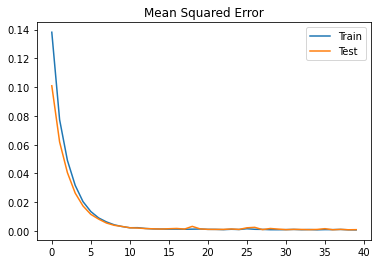

450/450 [==============================] - 0s 35us/step
MSE train: 0.00076, MSE test: 0.00087 MSE val: 0.00095


In [8]:
N_channels = 30
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/30_channels_data_3000.csv'
evaluate_model(N_channels, file_path)

(2800, 41) (600, 41) (600, 41) (2800, 40) (600, 40) (600, 40)
Train on 2800 samples, validate on 600 samples
Epoch 1/40
2800/2800 [==============================] - 1s 209us/step - loss: 0.1646 - mean_squared_error: 0.1646 - mean_absolute_error: 0.3876 - val_loss: 0.1213 - val_mean_squared_error: 0.1213 - val_mean_absolute_error: 0.3047
Epoch 2/40
2800/2800 [==============================] - 0s 70us/step - loss: 0.1017 - mean_squared_error: 0.1017 - mean_absolute_error: 0.2683 - val_loss: 0.0827 - val_mean_squared_error: 0.0827 - val_mean_absolute_error: 0.2384
Epoch 3/40
2800/2800 [==============================] - 0s 68us/step - loss: 0.0672 - mean_squared_error: 0.0672 - mean_absolute_error: 0.2113 - val_loss: 0.0542 - val_mean_squared_error: 0.0542 - val_mean_absolute_error: 0.1887
Epoch 4/40
2800/2800 [==============================] - 0s 69us/step - loss: 0.0431 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1639 - val_loss: 0.0344 - val_mean_squared_error: 0.0344 - val_me

Epoch 35/40
2800/2800 [==============================] - 0s 66us/step - loss: 4.9944e-04 - mean_squared_error: 4.9944e-04 - mean_absolute_error: 0.0172 - val_loss: 4.9884e-04 - val_mean_squared_error: 4.9884e-04 - val_mean_absolute_error: 0.0164
Epoch 36/40
2800/2800 [==============================] - 0s 66us/step - loss: 4.8169e-04 - mean_squared_error: 4.8169e-04 - mean_absolute_error: 0.0169 - val_loss: 6.2266e-04 - val_mean_squared_error: 6.2266e-04 - val_mean_absolute_error: 0.0198
Epoch 37/40
2800/2800 [==============================] - 0s 66us/step - loss: 5.2658e-04 - mean_squared_error: 5.2658e-04 - mean_absolute_error: 0.0176 - val_loss: 4.7577e-04 - val_mean_squared_error: 4.7577e-04 - val_mean_absolute_error: 0.0160
Epoch 38/40
2800/2800 [==============================] - 0s 68us/step - loss: 4.6341e-04 - mean_squared_error: 4.6341e-04 - mean_absolute_error: 0.0165 - val_loss: 5.5220e-04 - val_mean_squared_error: 5.5220e-04 - val_mean_absolute_error: 0.0166
Epoch 39/40
2800

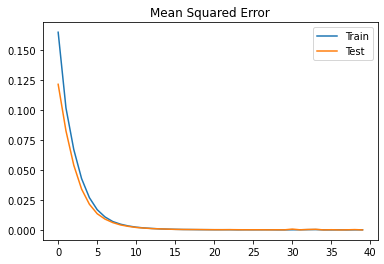

600/600 [==============================] - 0s 37us/step
MSE train: 0.00041, MSE test: 0.00047 MSE val: 0.00049


In [9]:
N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_4000.csv'
evaluate_model(N_channels, file_path)